<a href="https://www.kaggle.com/code/wsessoms/hw1-from-scratch-version?scriptVersionId=262709833" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# My From-Scratch Logistic Regression Model (No SKL)
## Final Submission Accuracy: .76794
## Final Submission Ranking: 8998

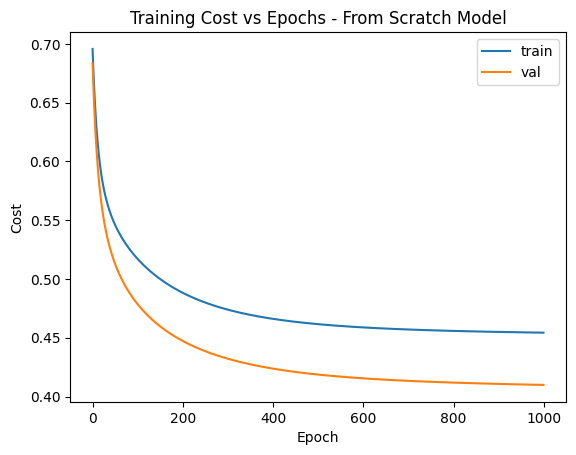

Training accuracy: 0.7952
Validation accuracy: 0.8284


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(z):
    y_hat =  1 / (1 + np.exp(-z))
    return y_hat

def initialize_params(m_features, seed=None):
    np.random.seed(seed)
    w = np.random.randn(m_features, 1) * .01
    return w, 0.0

def forward(X, w, b):
    z = X @ w + b
    y_hat = sigmoid(z)
    return z, y_hat

def compute_cost(y, y_hat):
    n = y.shape[0]
    cost = -(np.sum(y * np.log(y_hat) + (1-y) * np.log(1 - y_hat))) / n
    return cost

def compute_gradients(X, y, y_hat):
    n = X.shape[0]
    dw = (X.T @ (y_hat - y)) / n
    db = np.sum(y_hat - y) / n
    return dw, db

def update_params(w, b, dw, db, lr):
    w = w - lr * dw
    b = b - lr * db
    return w, b

def train(X, y, lr,n_epochs, X_val=None, y_val=None):
    w, b = initialize_params(X.shape[1], seed=865)

    train_cost = []
    val_cost = []

    for i in range(n_epochs):
        _, y_hat = forward(X, w, b)

        train_cost.append(compute_cost(y, y_hat))

        dw, db = compute_gradients(X, y, y_hat)
        w, b = update_params(w, b, dw, db, lr)

        if X_val is not None and y_val is not None:
            _, y_val_hat = forward(X_val, w, b)
            val_cost.append(compute_cost(y_val, y_val_hat))

    return w, b, train_cost, val_cost

def predict_proba(X, w, b):
    y, y_hat = forward(X, w, b)
    return y_hat


# --- My functions for preprocessing --- #

def my_ohe(train_df, test_df, cats):
    for cat in cats:
        train_ohe = pd.get_dummies(train_df[cat], prefix=cat, drop_first=True)
        test_ohe = pd.get_dummies(test_df[cat], prefix=cat, drop_first=True)
        test_ohe = test_ohe.reindex(columns=train_ohe.columns, fill_value = 0) # Ensures train and test have same columns
        
        train_df = pd.concat([train_df, train_ohe], axis=1)
        test_df = pd.concat([test_df, test_ohe], axis=1)
        train_df.drop([cat], axis=1, inplace=True)
        test_df.drop([cat], axis=1, inplace=True)

    return train_df, test_df

def my_minmax(train_df, test_df, cols):
    for col in cols:
        train_min = train_df[col].min()
        train_max = train_df[col].max()

        train_df[col] = (train_df[col] - train_min) / (train_max - train_min)
        test_df[col] = (test_df[col] - train_min) / (train_max - train_min)

    return train_df, test_df

def my_standard(train_df, test_df, cols):
    for col in cols:
        train_mean = train_df[col].mean()
        train_std = train_df[col].std()

        train_df[col] = (train_df[col] - train_mean) / train_std
        test_df[col] = (test_df[col] - train_mean) / train_std

    return train_df, test_df




# Read and copy data
train_df_ori = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df_ori = pd.read_csv('/kaggle/input/titanic/test.csv')

my_train_df = train_df_ori.copy()
my_test_df = test_df_ori.copy()

# Removing irrelevant features
irrelevant = ['PassengerId', 'Name']
my_train_df.drop(irrelevant, axis=1, inplace=True)
my_test_df.drop(irrelevant, axis=1, inplace=True)

# Removing features with too many missing values
missing = ['Cabin', 'Ticket']
my_train_df.drop(missing, axis=1, inplace=True)
my_test_df.drop(missing, axis=1, inplace=True)

# Impute missing age values using the mean
age_mean = my_train_df.loc[:, 'Age'].mean()
my_train_df.fillna({'Age': age_mean}, inplace=True)
my_test_df.fillna({'Age': age_mean}, inplace=True)


fare_mean = my_train_df.loc[:, 'Fare'].mean()
my_train_df.fillna({'Fare': fare_mean}, inplace=True)
my_test_df.fillna({'Fare': fare_mean}, inplace=True)

embarked_mode = my_train_df.loc[:, 'Embarked'].mode()
my_train_df.fillna({'Embarked': embarked_mode}, inplace=True)
my_test_df.fillna({'Embarked':embarked_mode}, inplace=True)


# display(my_train_df.tail())

# OHE with get_dummies
my_train_df, my_test_df = my_ohe(my_train_df, my_test_df, ['Sex', 'Embarked'])


# Minmax normalization on Pclass and Parch
my_train_df, my_test_df = my_minmax(my_train_df, my_test_df, ['SibSp', 'Parch'])


# Standardization of Age, SibSp, and Fare
my_train_df, my_test_df = my_standard(my_train_df, my_test_df, ['Age', 'Pclass', 'Fare'])


# display(my_train_df.tail())

# Split into training/val for x and y
X = my_train_df.drop(columns=['Survived']).values.astype(np.float64)
y = my_train_df['Survived'].values.reshape(-1, 1).astype(np.float64)

n_samples = X.shape[0]
indices = np.arange(n_samples)
np.random.seed(865)
np.random.shuffle(indices)
X, y = X[indices], y[indices]

split_at = int(n_samples * .85) # 85/15 split
X_train, X_val = X[:split_at], X[split_at:]
y_train, y_val = y[:split_at], y[split_at:]



learning_rate = .1
n_epochs = 1000

# Train
w, b, train_cost, val_cost = train(X_train, y_train, learning_rate, n_epochs, X_val, y_val)

plt.plot(train_cost, label='train')
plt.plot(val_cost, label='val')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Training Cost vs Epochs - From Scratch Model')
plt.legend()
plt.show()


# Predict on training set
y_hat_train = predict_proba(X_train, w, b)
y_pred_train = (y_hat_train >= 0.5).astype(int)
accuracy = np.mean(y_pred_train == y_train)
print(f"Training accuracy: {accuracy:.4f}")

#Predicting on validation set
y_hat_val = predict_proba(X_val, w, b)
y_pred_val = (y_hat_val >= 0.5).astype(int)
accuracy = np.mean(y_pred_val == y_val)
print(f"Validation accuracy: {accuracy:.4f}")


passenger_ids = test_df_ori['PassengerId']

# Predict on the test set
X_test = my_test_df.values.astype(np.float64)
y_hat_test = predict_proba(X_test, w, b)
y_pred_test = (y_hat_test >= 0.5).astype(int).flatten()

# Create submission DataFrame
submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': y_pred_test
})

# Save submission file
submission.to_csv('submission.csv', index=False)